In [539]:
import pandas as pd

In [540]:
full_dataset = pd.read_csv('./full_dataset.csv', sep='\t')


C:\Users\Dmitry\AppData\Local\Temp\ipykernel_22048\2684070288.py:1: DtypeWarning: Columns (3,7) have mixed types. Specify dtype option on import or set low_memory=False.
  full_dataset = pd.read_csv('./full_dataset.csv', sep='\t')


In [541]:
full_dataset

,napr,period,nastranapr,tnved,edizm,Stoim,Netto,Kol,Region,Region_s
0,ИМ,04/2019,CH,1904,NaN,"481,24","80,64",0,41000 - ЛЕНИНГРАДСКАЯ ОБЛАСТЬ,02-СЕВЕРО-ЗАПАДНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
1,ЭК,11/2019,CA,1904,NaN,"141,6","48,15",0,45000 - ГОРОД МОСКВА СТОЛИЦА РОССИЙСКОЙ ФЕДЕРА...,01-ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
2,ИМ,12/2019,DE,8481,NaN,"95803,6","1532,572",0,65000 - СВЕРДЛОВСКАЯ ОБЛАСТЬ,05-УРАЛЬСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
3,ИМ,12/2019,DE,8481,NaN,"22314,83","174,902",0,54000 - ОРЛОВСКАЯ ОБЛАСТЬ,01-ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
4,ИМ,12/2019,DE,8481,NaN,10386,"166,68",0,50000 - НОВОСИБИРСКАЯ ОБЛАСТЬ,06-СИБИРСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
...,...,...,...,...,...,...,...,...,...,...
6707331,ИМ,01/2022,CZ,7321,NaN,"91006,62","18381,844",0,28000 - ТВЕРСКАЯ ОБЛАСТЬ,01-ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
6707332,ИМ,01/2022,CN,7321,NaN,"6425,41","1496,8",0,81000 - РЕСПУБЛИКА БУРЯТИЯ,07-ДАЛЬНЕВОСТОЧНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
6707333,ИМ,01/2022,CN,7321,NaN,"304242,13","47602,548",0,65000 - СВЕРДЛОВСКАЯ ОБЛАСТЬ,05-УРАЛЬСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
6707334,ИМ,01/2022,CN,7321,NaN,"91971,17","15744,9",0,60000 - РОСТОВСКАЯ ОБЛАСТЬ,03-ЮЖНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ


In [542]:
def rename_id(id):
    four_numbers = str(id)[:4]
    if four_numbers == 'XXXX':
        return 9800
    else:
        return int(four_numbers)

In [543]:
full_dataset.tnved = full_dataset.tnved.apply(lambda x: rename_id(x))

In [544]:
def create_subtable(data, napr: str, tnved, region=None):
    if region == None: 
        subtable = data[(data.napr == napr) & (data.tnved == tnved)]
        # subtable.Stoim = subtable.Stoim.apply(lambda x: x.replace(',','.')).astype('float32')
        # subtable.period = pd.to_datetime(subtable.period)
        # subtable = subtable.sort_values(by=['period'], ascending=True)
        return subtable
    subtable = data[(data.napr == napr) & (data.tnved == tnved) & (data.Region == region)]
    # subtable.Stoim = subtable.Stoim.apply(lambda x: x.replace(',','.')).astype('float32')
    # subtable.period = pd.to_datetime(subtable.period)
    # subtable = subtable.sort_values(by=['period'], ascending=True)
    return subtable



In [555]:
def market_leaders(data: pd.DataFrame):
    data_group = data[data.period.dt.year == (data.period.dt.year - 1).values[-1]]
    data_group = pd.DataFrame(data_group.groupby(['nastranapr']).sum()['Stoim']).reset_index()
    data_group = data_group.sort_values(by=['Stoim'], ascending=True)
    arr = []
    full_sum = data_group.Stoim.sum()
    summary = 0
    i = 1
    while summary < full_sum/2:
        summary += data_group.Stoim.iloc[-i]
        arr.append(data_group.nastranapr.iloc[-i])
        i += 1
    return arr

In [546]:
def diff_leaders_nleaders(data: pd.DataFrame, leaders, count: int):
    data.period = data.period.values.astype('datetime64[M]').astype(int)
    data_group = data[data.period > (max(data.period) - count)]
    data_group = pd.DataFrame(data_group.groupby(['period', 'nastranapr'])['Stoim'].sum()).reset_index()
    leaders_stoim = data_group[[x in leaders for x in data_group.nastranapr]]
    not_leaders_stoim = data_group[[x not in leaders for x in data_group.nastranapr]]
    leaders_stoim_group = pd.DataFrame(leaders_stoim.groupby(['period'])['Stoim'].sum()).reset_index()
    not_leaders_stoim_group = pd.DataFrame(not_leaders_stoim.groupby(['period'])['Stoim'].sum()).reset_index()
    return leaders_stoim_group - not_leaders_stoim_group

In [547]:
def lin_reg(data):
    reg = LinearRegression()
    reg.fit(np.array(range(len(data))).reshape(-1, 1), data)
    coef = reg.coef_
    return coef

In [550]:
from itertools import product
def prepocess_dataset(data, n):
    def transform_tnved(s, n):
        s = str(s)[:n]
        try:
            s = int(s)
        except ValueError:
            s = int(98 * 10 ** (n-2))
        return s

    def transform_stoim(s):
        s = str(s)
        s = s.replace(',', '.')
        s = float(s)
        return s

    data.tnved = data.tnved.apply(transform_tnved, args=[n])
    data.Stoim = data.Stoim.apply(transform_stoim)
    data['period'] = pd.to_datetime(data.period)
    data = data.drop(['Netto', 'Kol', 'edizm', 'Region_s', 'Region'], axis=1)
    sums = data.groupby(['napr', 'period', 'tnved', 'nastranapr']).sum()
    sums = sums.reset_index()
    sums.period = sums.period.values.astype('datetime64[M]').astype(int)


    columns = ['napr', 'period', 'tnved', 'nastranapr']
    uniques = [sums[i].unique().tolist() for i in columns]
    all_dates = pd.DataFrame(product(*uniques), columns=columns)
    sums = pd.merge(all_dates, sums,
         how='left',
         on=columns)
    sums = sums.fillna(0)
    sums.period = sums.period.values.astype('datetime64[M]').astype('datetime64')
    return sums

In [551]:
data_fill_nan = prepocess_dataset(full_dataset, 4)

In [552]:
data_tnved = pd.DataFrame({'tnved' : full_dataset.tnved.unique(), 'metric_first':0, 'metric_second':0})
data_tnved

,tnved,metric_first,metric_second
0,1904,0,0
1,8481,0,0
2,4008,0,0
3,8466,0,0
4,2528,0,0
...,...,...,...
1199,2404,0,0
1200,8485,0,0
1201,3827,0,0
1202,8549,0,0


In [553]:
data_fill_nan

,napr,period,tnved,nastranapr,Stoim
0,ИМ,2019-01-01,101,BY,6705.00
1,ИМ,2019-01-01,101,UA,10848.93
2,ИМ,2019-01-01,101,CZ,0.00
3,ИМ,2019-01-01,101,DE,0.00
4,ИМ,2019-01-01,101,DK,0.00
...,...,...,...,...,...
22273995,ЭК,2022-01-01,309,BV,0.00
22273996,ЭК,2022-01-01,309,MF,0.00
22273997,ЭК,2022-01-01,309,GU,0.00
22273998,ЭК,2022-01-01,309,BL,0.00


In [567]:
leaders_list

[]

In [568]:
import numpy as np
from sklearn.linear_model import LinearRegression
count = 12
test_df = create_subtable(data_fill_nan, "ИМ", 309)
leaders_list = market_leaders(test_df)
if leaders_list != []:
    tmp= diff_leaders_nleaders(test_df, leaders_list, count)
    tmp.Stoim = (tmp.Stoim - tmp.Stoim.mean())/tmp.Stoim.std()
    lin_reg(tmp.Stoim)

In [ ]:
tmp

,period,Stoim
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [564]:
data_fill_nan.tnved.unique()[-1]

309

In [596]:
import numpy as np
from sklearn.linear_model import LinearRegression
from tqdm import trange
count = 12
lin_ref_arr = []
for i in trange(len(data_fill_nan.tnved.unique())):
    test_df = create_subtable(data_fill_nan, "ИМ", data_fill_nan.tnved.unique()[i])
    leaders_list = market_leaders(test_df)
    if leaders_list != []:
        tmp = diff_leaders_nleaders(test_df, leaders_list, count)
        tmp.Stoim = (tmp.Stoim - tmp.Stoim.mean())/tmp.Stoim.std()
        lin = lin_reg(tmp.Stoim)[0]
        lin_ref_arr.append(lin)
    else:
        lin_ref_arr.append(10000)

  0%|          | 0/1204 [00:00<?, ?it/s]C:\Users\Dmitry\AppData\Local\Temp\ipykernel_22048\1026855274.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.period = data.period.values.astype('datetime64[M]').astype(int)
  0%|          | 1/1204 [00:00<16:06,  1.25it/s]C:\Users\Dmitry\AppData\Local\Temp\ipykernel_22048\1026855274.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.period = data.period.values.astype('datetime64[M]').astype(int)
  0%|          | 2/1204 [00:01<16:08,  1.24it/s]C:\Users\D

In [597]:
data_tnved.metric_first = lin_ref_arr

In [598]:

data_tnved

,tnved,metric_first,metric_second
0,1904,0.132833,0
1,8481,0.153671,0
2,4008,0.113416,0
3,8466,0.066946,0
4,2528,-0.026477,0
...,...,...,...
1199,2404,10000.000000,0
1200,8485,10000.000000,0
1201,3827,10000.000000,0
1202,8549,10000.000000,0


In [599]:
data_tnved.to_csv('data_tnved_metric.csv', index = False, sep=';')

--------------------------------------------------------------------------------

In [ ]:
test_df

,napr,period,nastranapr,tnved,edizm,Stoim,Netto,Kol,Region,Region_s
559986,ИМ,2019-01-01,CN,7321,NaN,2.267191e+04,"7525,3",0,50000 - НОВОСИБИРСКАЯ ОБЛАСТЬ,06-СИБИРСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
560019,ИМ,2019-01-01,BY,7321,NaN,8.740000e+00,"2,2",0,33000 - КИРОВСКАЯ ОБЛАСТЬ,04-ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
560018,ИМ,2019-01-01,BY,7321,NaN,4.687614e+05,"120395,799",0,36000 - САМАРСКАЯ ОБЛАСТЬ,04-ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
560017,ИМ,2019-01-01,BY,7321,NaN,2.250779e+06,"542277,5",0,45000 - ГОРОД МОСКВА СТОЛИЦА РОССИЙСКОЙ ФЕДЕРА...,01-ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
1137651,ИМ,2019-01-01,KZ,7321,NaN,1.211500e+02,"71,74",0,01000 - АЛТАЙСКИЙ КРАЙ,06-СИБИРСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
...,...,...,...,...,...,...,...,...,...,...
6694955,ИМ,2022-01-01,CN,7321,NaN,1.123500e+02,10,0,66000 - СМОЛЕНСКАЯ ОБЛАСТЬ,01-ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
6694953,ИМ,2022-01-01,FI,7321,NaN,2.029040e+03,53,0,86000 - РЕСПУБЛИКА КАРЕЛИЯ,02-СЕВЕРО-ЗАПАДНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
6694951,ИМ,2022-01-01,IT,7321,NaN,3.931759e+04,"6227,561",0,40000 - ГОРОД САНКТ-ПЕТЕРБУРГ ГОРОД ФЕДЕРАЛЬНО...,02-СЕВЕРО-ЗАПАДНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
6695218,ИМ,2022-01-01,UZ,7321,NaN,6.840000e+02,"194,7",0,60000 - РОСТОВСКАЯ ОБЛАСТЬ,03-ЮЖНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ


In [ ]:
leaders_list

['BY', 'CN']

In [ ]:
test_df

,napr,period,nastranapr,tnved,edizm,Stoim,Netto,Kol,Region,Region_s
559986,ИМ,2019-01-01,CN,7321,NaN,2.267191e+04,"7525,3",0,50000 - НОВОСИБИРСКАЯ ОБЛАСТЬ,06-СИБИРСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
560019,ИМ,2019-01-01,BY,7321,NaN,8.740000e+00,"2,2",0,33000 - КИРОВСКАЯ ОБЛАСТЬ,04-ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
560018,ИМ,2019-01-01,BY,7321,NaN,4.687614e+05,"120395,799",0,36000 - САМАРСКАЯ ОБЛАСТЬ,04-ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
560017,ИМ,2019-01-01,BY,7321,NaN,2.250779e+06,"542277,5",0,45000 - ГОРОД МОСКВА СТОЛИЦА РОССИЙСКОЙ ФЕДЕРА...,01-ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
1137651,ИМ,2019-01-01,KZ,7321,NaN,1.211500e+02,"71,74",0,01000 - АЛТАЙСКИЙ КРАЙ,06-СИБИРСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
...,...,...,...,...,...,...,...,...,...,...
6694955,ИМ,2022-01-01,CN,7321,NaN,1.123500e+02,10,0,66000 - СМОЛЕНСКАЯ ОБЛАСТЬ,01-ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
6694953,ИМ,2022-01-01,FI,7321,NaN,2.029040e+03,53,0,86000 - РЕСПУБЛИКА КАРЕЛИЯ,02-СЕВЕРО-ЗАПАДНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
6694951,ИМ,2022-01-01,IT,7321,NaN,3.931759e+04,"6227,561",0,40000 - ГОРОД САНКТ-ПЕТЕРБУРГ ГОРОД ФЕДЕРАЛЬНО...,02-СЕВЕРО-ЗАПАДНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
6695218,ИМ,2022-01-01,UZ,7321,NaN,6.840000e+02,"194,7",0,60000 - РОСТОВСКАЯ ОБЛАСТЬ,03-ЮЖНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ


In [ ]:
len(test_df.nastranapr.unique())

56

In [ ]:
len(data_group)

49

In [ ]:
full_dataset.tnved.unique()

array([1904, 8481, 4008, ..., 3827, 8549,  309], dtype=int64)

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
reg = LinearRegression()
reg.fit(np.array(range(12)).reshape(-1, 1), tmp)

LinearRegression()

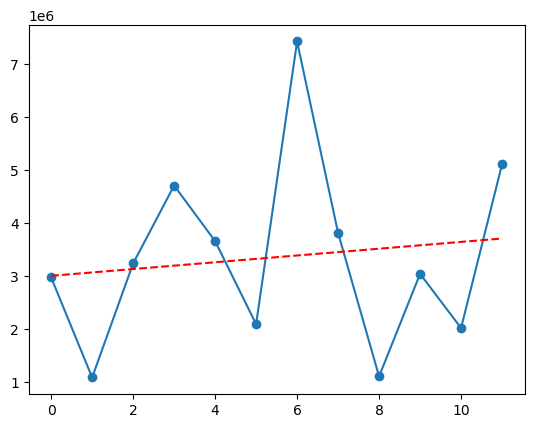

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list(range(12)),tmp,'-o')
plt.plot(list(range(12)),reg.predict(np.array(range(12)).reshape(-1, 1)),'--', color='red')


In [ ]:
reg.coef_

array([64058.52097902])

In [ ]:
full_dataset

,napr,period,nastranapr,tnved,edizm,Stoim,Netto,Kol,Region,Region_s
0,ИМ,04/2019,CH,1904,NaN,"481,24","80,64",0,41000 - ЛЕНИНГРАДСКАЯ ОБЛАСТЬ,02-СЕВЕРО-ЗАПАДНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
1,ЭК,11/2019,CA,1904,NaN,"141,6","48,15",0,45000 - ГОРОД МОСКВА СТОЛИЦА РОССИЙСКОЙ ФЕДЕРА...,01-ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
2,ИМ,12/2019,DE,8481,NaN,"95803,6","1532,572",0,65000 - СВЕРДЛОВСКАЯ ОБЛАСТЬ,05-УРАЛЬСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
3,ИМ,12/2019,DE,8481,NaN,"22314,83","174,902",0,54000 - ОРЛОВСКАЯ ОБЛАСТЬ,01-ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
4,ИМ,12/2019,DE,8481,NaN,10386,"166,68",0,50000 - НОВОСИБИРСКАЯ ОБЛАСТЬ,06-СИБИРСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
...,...,...,...,...,...,...,...,...,...,...
6707331,ИМ,01/2022,CZ,7321,NaN,"91006,62","18381,844",0,28000 - ТВЕРСКАЯ ОБЛАСТЬ,01-ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
6707332,ИМ,01/2022,CN,7321,NaN,"6425,41","1496,8",0,81000 - РЕСПУБЛИКА БУРЯТИЯ,07-ДАЛЬНЕВОСТОЧНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
6707333,ИМ,01/2022,CN,7321,NaN,"304242,13","47602,548",0,65000 - СВЕРДЛОВСКАЯ ОБЛАСТЬ,05-УРАЛЬСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
6707334,ИМ,01/2022,CN,7321,NaN,"91971,17","15744,9",0,60000 - РОСТОВСКАЯ ОБЛАСТЬ,03-ЮЖНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ
